# ACG Testing Script

In [1]:

import os, json, time, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, Markdown

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

UPLOADED_SCRIPT_PATH = "./psychrnn_perceptualdiscrimination_noise_comparison.py"
if Path(UPLOADED_SCRIPT_PATH).exists():
    display(Markdown(f"**Found uploaded script:** `{UPLOADED_SCRIPT_PATH}`"))
else:
    display(Markdown(f"**No uploaded script found at** `{UPLOADED_SCRIPT_PATH}`"))


Device: cuda


**No uploaded script found at** `./psychrnn_perceptualdiscrimination_noise_comparison.py`

In [2]:

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def savefig(fig, path, dpi=150):
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    print("Saved:", path)


In [3]:

def generate_batch(batch_size, T, coherence, stim_std=1.0, input_dim=2, device='cpu'):
    labels = np.random.choice([0,1], size=(batch_size,))
    x = np.random.randn(batch_size, T, input_dim) * stim_std
    for i, lab in enumerate(labels):
        x[i, :, lab] += coherence
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    y_t = torch.tensor(labels, dtype=torch.long, device=device)
    return x_t, y_t


In [4]:

class RNNWithGateDale(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=80, output_dim=2,
                 rec_noise_std=0.0, gate=True, dale=True, dale_exc_frac=0.8, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.rec_noise_std = rec_noise_std
        self.gate = gate
        self.dale = dale
        self.device = device

        # parameters
        self.W_in = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
        self.b_in = nn.Parameter(torch.zeros(hidden_dim))
        self.W_rec_raw = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * (1.0/np.sqrt(hidden_dim)))
        self.b_rec = nn.Parameter(torch.zeros(hidden_dim))
        self.W_out = nn.Linear(hidden_dim, output_dim)
        if self.gate:
            self.W_gate = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
            self.b_gate = nn.Parameter(torch.zeros(hidden_dim))
        if self.dale:
            n_exc = int(round(dale_exc_frac * hidden_dim))
            signs = np.array([1]*n_exc + [-1]*(hidden_dim-n_exc))
            np.random.shuffle(signs)
            self.register_buffer('dale_sign', torch.tensor(signs, dtype=torch.float32).to(device))
        else:
            self.register_buffer('dale_sign', torch.ones(hidden_dim, dtype=torch.float32).to(device))
        self.activation = torch.tanh

    def effective_Wrec(self):
        W_abs = torch.abs(self.W_rec_raw)
        W = W_abs * self.dale_sign.unsqueeze(0)
        return W

    def forward(self, x, return_hidden=False):
        batch, T, _ = x.size()
        h = torch.zeros(batch, self.hidden_dim, device=x.device)
        hs = []
        W_rec = self.effective_Wrec()
        for t in range(T):
            xt = x[:, t, :]
            inp = torch.matmul(xt, self.W_in.t()) + self.b_in
            if self.gate:
                g = torch.sigmoid(torch.matmul(xt, self.W_gate.t()) + self.b_gate)
                inp = inp * g
            rec = torch.matmul(h, W_rec.t()) + self.b_rec
            h = self.activation(inp + rec)
            if self.rec_noise_std and self.training:
                h = h + torch.randn_like(h) * float(self.rec_noise_std)
            hs.append(h.unsqueeze(1))
        hs = torch.cat(hs, dim=1)
        logits = self.W_out(hs[:, -1, :])
        if return_hidden:
            return logits, hs
        return logits


In [5]:

def compute_accuracy(model, coherence, n_trials=256, batch_size=64, T=40, stim_std=1.0, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        while total < n_trials:
            b = min(batch_size, n_trials - total)
            x, y = generate_batch(b, T, coherence, stim_std=stim_std, device=device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += b
    return correct / total

def psychometric_curve(model, coherences, n_trials_each=300, batch_size=64, T=40, stim_std=1.0, device='cpu'):
    accs = []
    for c in coherences:
        acc = compute_accuracy(model, c, n_trials=n_trials_each, batch_size=batch_size, T=T, stim_std=stim_std, device=device)
        accs.append(acc)
    return np.array(accs)

def fit_consistent_pca(models, names, coherence=0.4, T=40, trials_per_model=8, device='cpu'):
    all_h = []
    with torch.no_grad():
        for name, model in zip(names, models):
            model.eval()
            for _ in range(trials_per_model):
                x, y = generate_batch(1, T, coherence, device=device)
                _, hs = model(x, return_hidden=True)
                all_h.append(hs[0].cpu().numpy())
    all_h_concat = np.concatenate(all_h, axis=0)
    pca = PCA(n_components=3)
    pca.fit(all_h_concat)
    return pca

def pca_traj_in_pca(model, pca, coherence=0.4, T=40, device='cpu'):
    model.eval()
    with torch.no_grad():
        x, y = generate_batch(1, T, coherence, device=device)
        _, hs = model(x, return_hidden=True)
        h = hs[0].cpu().numpy()
    traj = pca.transform(h)
    return traj, int(y.cpu().numpy()[0])


In [6]:

def contrastive_centroid_loss(hidden_states, labels, margin=1.0):
    labels = labels.cpu().numpy()
    hs = hidden_states.cpu().detach().numpy()
    if len(np.unique(labels)) < 2:
        return torch.tensor(0.0, device=hidden_states.device)
    mu0 = torch.tensor(hs[labels==0].mean(axis=0), device=hidden_states.device)
    mu1 = torch.tensor(hs[labels==1].mean(axis=0), device=hidden_states.device)
    dist = torch.norm(mu0 - mu1)
    loss = torch.relu(margin - dist)
    return loss


In [16]:

def train_model_acg(seed=0, training_iters=4000, batch_size=64, T=40, hidden_dim=80,
                    lr=1e-3, rec_noise=0.0, gate=True, dale=True, dale_exc_frac=0.8,
                    start_coh=0.6, min_coh=0.2, coh_step=0.1, mode='baseline',
                    eval_interval=200, target_acc=0.8, contrastive_lambda=0.0, margin=1.0,
                    outdir='out_acg', device='cpu', verbose=True):
    set_seed(seed)
    os.makedirs(outdir, exist_ok=True)
    model = RNNWithGateDale(input_dim=2, hidden_dim=hidden_dim, output_dim=2,
                            rec_noise_std=rec_noise, gate=gate, dale=dale, dale_exc_frac=dale_exc_frac,
                            device=device).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    psych_history = []
    eval_coherences = [0.2, 0.4, 0.6, 0.8]
    coher = float(start_coh)
    it = 0
    while it < training_iters:
        model.train()
        x, y = generate_batch(batch_size, T, coher, device=device)
        opt.zero_grad()
        logits, hs = model(x, return_hidden=True)
        loss = loss_fn(logits, y)
        final_h = hs[:, -1, :]
        if contrastive_lambda > 0.0:
            c_loss = contrastive_centroid_loss(final_h, y, margin=margin)
            loss = loss + contrastive_lambda * c_loss
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
        it += 1
        if it % eval_interval == 0:
            val_acc = compute_accuracy(model, coher, n_trials=256, batch_size=batch_size, T=T, device=device)
            psych = psychometric_curve(model, eval_coherences, n_trials_each=200, batch_size=batch_size, T=T, device=device)
            psych_history.append({'iter':int(it), 'coherence':float(coher), 'val_acc':float(val_acc), 'psych':psych.tolist()})
            if verbose:
                print(f"[{outdir}] iter {it} | coh {coher:.2f} | loss {loss.item():.4f} | val_acc {val_acc:.3f}")
            if mode=='curriculum' and val_acc >= target_acc and (coher - coh_step) >= min_coh:
                coher = max(min_coh, coher - coh_step)
                if verbose:
                    print(f"  -> lowered coherence to {coher:.2f} at iter {it}")
    final_psych = psychometric_curve(model, eval_coherences, n_trials_each=400, batch_size=batch_size, T=T, device=device)
    torch.save(model.state_dict(), os.path.join(outdir, 'model_state.pt'))
    results = {
        'losses': list(map(float, losses)),
        'psych_history': psych_history,
        'final_psych': list(map(float, final_psych)),
        'eval_coherences': list(map(float, eval_coherences)),
        'params': {
            'seed':int(seed), 'training_iters':int(training_iters), 'batch_size':int(batch_size),
            'T':int(T), 'hidden_dim':int(hidden_dim), 'lr':float(lr), 'rec_noise':float(rec_noise),
            'gate':bool(gate), 'dale':bool(dale), 'start_coh':float(start_coh), 'mode':mode,
            'contrastive_lambda':float(contrastive_lambda), 'margin':float(margin)
        }
    }
    with open(os.path.join(outdir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=2)
    return model, results


In [17]:

# Run demo experiments (fast)
OUT = Path('./out_acg_demo')
OUT.mkdir(exist_ok=True)

SEED = 0
TRAIN_ITERS = 2000
BATCH_SIZE = 128
T = 40
HIDDEN = 128
LR = 1e-3

exps = {
    'baseline': {'rec_noise':0.0, 'gate':False, 'contrastive_lambda':0.0, 'mode':'baseline', 'start_coh':0.2},
    'gating':   {'rec_noise':0.0, 'gate':True,  'contrastive_lambda':0.0, 'mode':'baseline', 'start_coh':0.2},
    'acg':      {'rec_noise':0.0, 'gate':True,  'contrastive_lambda':1.0, 'mode':'baseline', 'start_coh':0.2},
    'curr_acg': {'rec_noise':0.0, 'gate':True,  'contrastive_lambda':1.0, 'mode':'curriculum', 'start_coh':0.8}
}

models = {}
results = {}
for name, cfg in exps.items():
    outdir = str(OUT / name)
    print('\n=== RUN', name)
    model, res = train_model_acg(
        seed=SEED, training_iters=TRAIN_ITERS, batch_size=BATCH_SIZE, T=T, hidden_dim=HIDDEN,
        lr=LR, rec_noise=cfg['rec_noise'], gate=cfg['gate'], dale=True, dale_exc_frac=0.8,
        start_coh=cfg['start_coh'], mode=cfg['mode'], eval_interval=200, target_acc=0.80,
        contrastive_lambda=cfg['contrastive_lambda'], margin=1.0, outdir=outdir, device='cpu', verbose=True
    )
    models[name] = model
    results[name] = res
    print('Saved ->', outdir)



=== RUN baseline
[out_acg_demo/baseline] iter 200 | coh 0.20 | loss 0.6892 | val_acc 0.559
[out_acg_demo/baseline] iter 400 | coh 0.20 | loss 0.6822 | val_acc 0.598
[out_acg_demo/baseline] iter 600 | coh 0.20 | loss 0.6779 | val_acc 0.590
[out_acg_demo/baseline] iter 800 | coh 0.20 | loss 0.6755 | val_acc 0.594
[out_acg_demo/baseline] iter 1000 | coh 0.20 | loss 0.6862 | val_acc 0.555
[out_acg_demo/baseline] iter 1200 | coh 0.20 | loss 0.6771 | val_acc 0.621
[out_acg_demo/baseline] iter 1400 | coh 0.20 | loss 0.6964 | val_acc 0.566
[out_acg_demo/baseline] iter 1600 | coh 0.20 | loss 0.6820 | val_acc 0.578
[out_acg_demo/baseline] iter 1800 | coh 0.20 | loss 0.6869 | val_acc 0.531
[out_acg_demo/baseline] iter 2000 | coh 0.20 | loss 0.6697 | val_acc 0.539
Saved -> out_acg_demo/baseline

=== RUN gating
[out_acg_demo/gating] iter 200 | coh 0.20 | loss 0.6751 | val_acc 0.617
[out_acg_demo/gating] iter 400 | coh 0.20 | loss 0.6953 | val_acc 0.578
[out_acg_demo/gating] iter 600 | coh 0.20 | l

Saved: ./out_acg_demo/losses.png
Saved: ./out_acg_demo/psych.png
Saved: ./out_acg_demo/pca.png


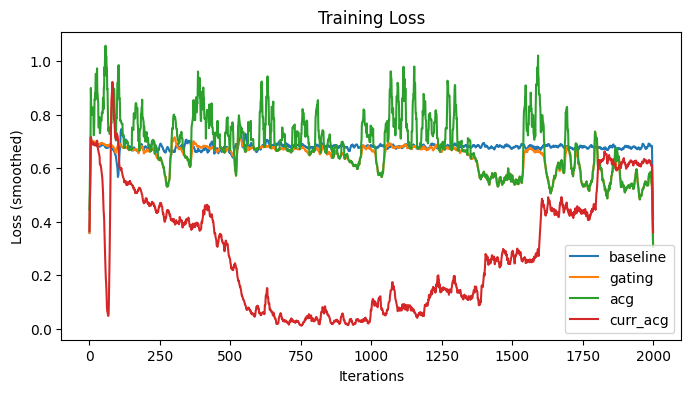

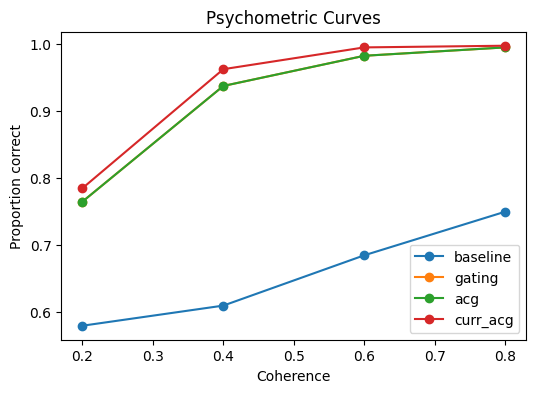

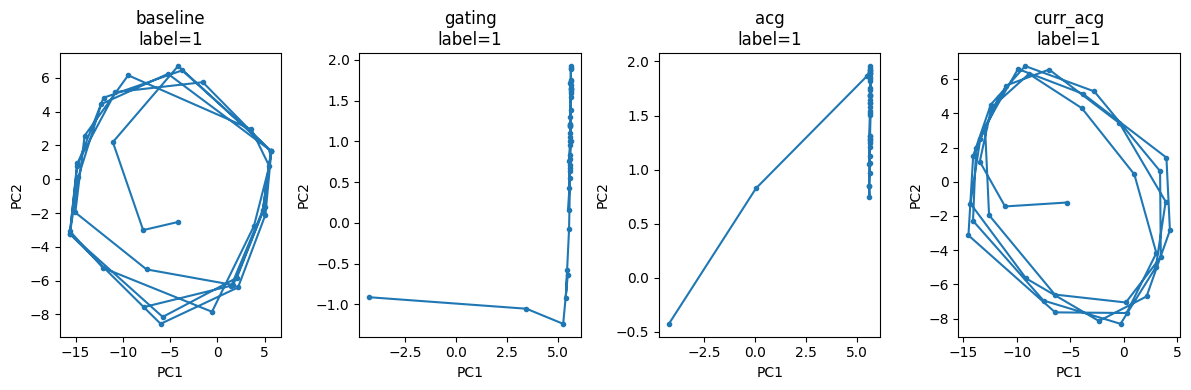

In [18]:

# Plot results
def plot_loss(results, outpath):
    plt.figure(figsize=(8,4))
    for k,v in results.items():
        losses = np.array(v['losses'])
        if len(losses)>10:
            smooth = np.convolve(losses, np.ones(10)/10, mode='same')
        else:
            smooth = losses
        plt.plot(smooth, label=k)
    plt.xlabel('Iterations'); plt.ylabel('Loss (smoothed)'); plt.legend(); plt.title('Training Loss')
    savefig(plt, outpath)

def plot_psych(results, outpath):
    plt.figure(figsize=(6,4))
    for k,v in results.items():
        coh = np.array(v['eval_coherences'])
        psych = np.array(v['final_psych'])
        plt.plot(coh, psych, '-o', label=k)
    plt.xlabel('Coherence'); plt.ylabel('Proportion correct'); plt.legend(); plt.title('Psychometric Curves')
    savefig(plt, outpath)

plot_loss(results, './out_acg_demo/losses.png')
plot_psych(results, './out_acg_demo/psych.png')

pca = fit_consistent_pca(list(models.values()), list(models.keys()), coherence=0.4, T=T, trials_per_model=8, device='cpu')
plt.figure(figsize=(12,4))
for i,name in enumerate(models.keys()):
    traj, lab = pca_traj_in_pca(models[name], pca, coherence=0.4, T=T, device='cpu')
    ax = plt.subplot(1, len(models), i+1)
    ax.plot(traj[:,0], traj[:,1], '-o', markersize=3)
    ax.set_title(f"{name}\nlabel={lab}")
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.tight_layout()
savefig(plt, './out_acg_demo/pca.png')
plt.show()
